# Trabalho 1
Matéria: Processamento de Linguagem Natural <br>
Dupla/Matrícula: Bianca Nunes Coelho - 15102880, Raíssa Nunes Coelho - 15102887 <br> 

## Introdução

Multi Class Classification <br>

## Bibliotecas
Bibliotecas do ptyhon utilizadas neste trabalho estão a seguir.

In [1]:
import pandas as pd
import re
import nltk
import spacy
import gensim
import matplotlib.pyplot as plt

## Datasets
Datasets utilizados estão definidos a seguir.

In [2]:
file = "train-00000-of-00001-ecf072e7202447d8.parquet"
df = pd.read_parquet(file, engine= 'pyarrow')

In [3]:
len(df)

3877

In [4]:
df.head(4)

,titulo,texto,link,resumo,categoria,data_hora
0,"Veja a trajetória de Fernando Diniz, em busca ...",Se tem um treinador que sempre foi badalado pe...,https://www.cnnbrasil.com.br/esportes/veja-a-t...,Técnico tricolor e da Seleção Brasileira tem a...,esportes,2023-11-04 12:26:18
1,"Após tempestade com ventos, São Paulo terá sáb...",Após uma tempestade com ventos de mais de 100 ...,https://www.cnnbrasil.com.br/nacional/apos-tem...,"Termômetros devem chegar a 26ºC, esquentando a...",nacional,2023-11-04 12:15:44
2,Como os aplicativos de relacionamento “arruina...,Jenny Nguyen-Don estava com vontade de comer f...,https://www.cnnbrasil.com.br/tecnologia/como-o...,Pessoas em busca de relacionamentos afirmam qu...,tecnologia,2023-11-04 12:15:07
3,Fluminense pode ser o 26º clube a levantar a t...,O Fluminense vai em busca do primeiro título d...,https://www.cnnbrasil.com.br/esportes/fluminen...,"Em busca do título inédito, o Tricolor carioca...",esportes,2023-11-04 12:05:24


## Balanceamento

In [5]:
df['categoria'].value_counts()

esportes           960
nacional           623
internacional      618
economia           562
politica           507
entretenimento     450
tecnologia          44
saude               41
noticias            38
lifestyle           21
branded-content     13
Name: categoria, dtype: int64

<AxesSubplot: >

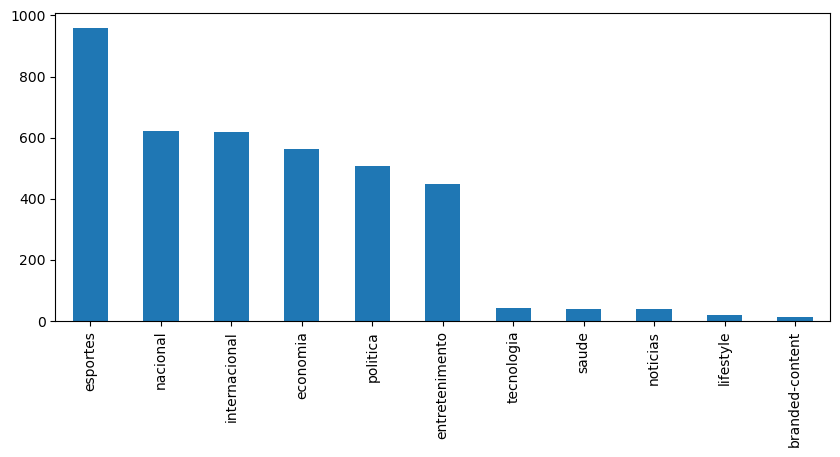

In [6]:
plt.figure(figsize=(10,4))
df.categoria.value_counts().plot(kind='bar')

In [7]:
indice_linha_remover = ['tecnologia',  'saude','noticias','lifestyle','branded-content']

In [8]:
df = df[~df['categoria'].isin(indice_linha_remover)]

In [9]:
df['categoria'].value_counts()

esportes          960
nacional          623
internacional     618
economia          562
politica          507
entretenimento    450
Name: categoria, dtype: int64

In [10]:
# Undersampling
min = df['categoria'].value_counts().min()

amostras = []

for i in df['categoria'].value_counts().index:
    a = df[df['categoria'] == i].sample(min, replace=False)
    amostras.append(a)

df_balanceado = pd.concat(amostras)

In [11]:
df_balanceado['categoria'].value_counts()

esportes          450
nacional          450
internacional     450
economia          450
politica          450
entretenimento    450
Name: categoria, dtype: int64

In [12]:
df_balanceado = df_balanceado.reset_index(drop=True)
df_balanceado.head(5)

,titulo,texto,link,resumo,categoria,data_hora
0,Surfista australiana supera brasileira e quebr...,A surfista australiana Laura Enever pode comem...,https://www.cnnbrasil.com.br/esportes/surfista...,Laura Enever entrou para o Guiness World Recor...,esportes,2023-11-09 15:58:20
1,Guardiola parabeniza Flu e diz que “gostaria d...,"O treinador Pep Guardiola, do Manchester City,...",https://www.cnnbrasil.com.br/esportes/guardiol...,Declaração foi dada após a vitória por 3 a 0 s...,esportes,2023-11-08 14:16:23
2,PSG X Newcastle: tempo real e onde assistir ao...,PSG e Newcastle entram em campo nesta terça-fe...,https://www.cnnbrasil.com.br/esportes/psg-x-ne...,Onde assistir e tempo real dos lances e das es...,esportes,2023-11-28 11:31:14
3,Flamengo x Atlético-MG: Ingressos esgotados pa...,"Na briga pelo título do Campeonato Brasileiro,...",https://www.cnnbrasil.com.br/esportes/flamengo...,Arquibancadas do Maracanã estarão lotadas para...,esportes,2023-11-28 15:57:18
4,"Cruzeiro quer manter Bruno Rodrigues, mas pede...","O Cruzeiro procurou o Tombense e sinalizou, em...",https://www.cnnbrasil.com.br/esportes/cruzeiro...,Atacante pertence ao Tombense e já poderia ass...,esportes,2023-11-20 22:33:22


In [13]:
# pega coluna
text = df_balanceado['texto']
len(text)

2700

In [14]:
categorias = ['esportes','nacional', 'internacional', 'economia', 'politica', 'entretenimento']

## Pré-processamento

In [15]:
for i in range(len(text)):
    text[i] = text[i].lower()

In [16]:
from unidecode import unidecode

for i in range(len(text)):
    text[i] = unidecode(text[i])

In [17]:
for i in range(len(text)):
    text[i] = re.sub(r'[^a-zA-Z\s]', "" ,text[i])

In [18]:
print(text[0])

a surfista australiana laura enever pode comemorar oficialmente a quebra do recorde mundial da maior onda ja surfada por uma mulher na remada o guinness world records e a world surf league wsl anunciaram o tamanho da onda de  metros que ela surfou com sucesso no havai em  de janeiro remar exige que os surfistas entrem nas ondas sem ajuda diferente da outra categoria em que os atletas sao levados por um jetski para acessar as maiores ondas quando olhei para baixo sabia que era definitivamente a maior onda que ja peguei eu sabia que era a onda da minha vida a forma como tudo aconteceu e a forma como me comprometi disse a mim mesma para ir e confiei que conseguiria a prova foi um grande avanco para mim e um momento que sera realmente especial e monumental na minha carreira de surf ser premiada meses depois e muito legal nao consigo acreditar disse enever  leia mais  o recorde anterior foi ha oito anos da surfista brasileira andrea moller  a brasileira surfou uma onda de  metros tambem no 

### NLTK

In [19]:
token_text = []

for j in text:
    token_text.append(nltk.word_tokenize(j))

In [20]:
print(token_text[0])

['a', 'surfista', 'australiana', 'laura', 'enever', 'pode', 'comemorar', 'oficialmente', 'a', 'quebra', 'do', 'recorde', 'mundial', 'da', 'maior', 'onda', 'ja', 'surfada', 'por', 'uma', 'mulher', 'na', 'remada', 'o', 'guinness', 'world', 'records', 'e', 'a', 'world', 'surf', 'league', 'wsl', 'anunciaram', 'o', 'tamanho', 'da', 'onda', 'de', 'metros', 'que', 'ela', 'surfou', 'com', 'sucesso', 'no', 'havai', 'em', 'de', 'janeiro', 'remar', 'exige', 'que', 'os', 'surfistas', 'entrem', 'nas', 'ondas', 'sem', 'ajuda', 'diferente', 'da', 'outra', 'categoria', 'em', 'que', 'os', 'atletas', 'sao', 'levados', 'por', 'um', 'jetski', 'para', 'acessar', 'as', 'maiores', 'ondas', 'quando', 'olhei', 'para', 'baixo', 'sabia', 'que', 'era', 'definitivamente', 'a', 'maior', 'onda', 'que', 'ja', 'peguei', 'eu', 'sabia', 'que', 'era', 'a', 'onda', 'da', 'minha', 'vida', 'a', 'forma', 'como', 'tudo', 'aconteceu', 'e', 'a', 'forma', 'como', 'me', 'comprometi', 'disse', 'a', 'mim', 'mesma', 'para', 'ir', 'e

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/hworld/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
from nltk.corpus import stopwords
sw = stopwords.words('portuguese')

In [23]:
for stop in sw:
    for text in token_text:
        for t in text:
            if(t == stop):
                text.remove(t)

In [24]:
print(token_text[0])

['surfista', 'australiana', 'laura', 'enever', 'pode', 'comemorar', 'oficialmente', 'quebra', 'recorde', 'mundial', 'maior', 'onda', 'ja', 'surfada', 'mulher', 'remada', 'guinness', 'world', 'records', 'world', 'surf', 'league', 'wsl', 'anunciaram', 'tamanho', 'onda', 'metros', 'surfou', 'sucesso', 'havai', 'janeiro', 'remar', 'exige', 'surfistas', 'entrem', 'ondas', 'ajuda', 'diferente', 'outra', 'categoria', 'atletas', 'sao', 'levados', 'jetski', 'acessar', 'maiores', 'ondas', 'olhei', 'baixo', 'sabia', 'definitivamente', 'maior', 'onda', 'ja', 'peguei', 'sabia', 'onda', 'vida', 'forma', 'tudo', 'aconteceu', 'forma', 'comprometi', 'disse', 'mim', 'mesma', 'ir', 'confiei', 'conseguiria', 'prova', 'grande', 'avanco', 'mim', 'momento', 'sera', 'realmente', 'especial', 'monumental', 'carreira', 'surf', 'premiada', 'meses', 'legal', 'nao', 'consigo', 'acreditar', 'disse', 'enever', 'leia', 'recorde', 'anterior', 'ha', 'oito', 'anos', 'surfista', 'brasileira', 'andrea', 'moller', 'brasilei

In [29]:
df_balanceado['texto'] = token_text
df_balanceado.head(2)

,titulo,texto,link,resumo,categoria,data_hora
0,Surfista australiana supera brasileira e quebr...,"[surfista, australiana, laura, enever, pode, c...",https://www.cnnbrasil.com.br/esportes/surfista...,Laura Enever entrou para o Guiness World Recor...,esportes,2023-11-09 15:58:20
1,Guardiola parabeniza Flu e diz que “gostaria d...,"[treinador, pep, guardiola, manchester, city, ...",https://www.cnnbrasil.com.br/esportes/guardiol...,Declaração foi dada após a vitória por 3 a 0 s...,esportes,2023-11-08 14:16:23


## Análises

In [34]:
from collections import Counter  # Contagem de frequência de palavras usando NLTK 
frequencia_palavras = Counter(token_text[1]) 
print(frequencia_palavras.most_common())

[('sobre', 5), ('diniz', 3), ('fluminense', 3), ('mundial', 3), ('clubes', 3), ('treinador', 2), ('guardiola', 2), ('manchester', 2), ('city', 2), ('fernando', 2), ('libertadores', 2), ('gostaria', 2), ('saber', 2), ('dinizismo', 2), ('pep', 1), ('parabenizou', 1), ('conquista', 1), ('copa', 1), ('garantiu', 1), ('declaracao', 1), ('dada', 1), ('tnt', 1), ('sports', 1), ('apos', 1), ('vitoria', 1), ('young', 1), ('boys', 1), ('etihad', 1), ('stadium', 1), ('grupo', 1), ('g', 1), ('champions', 1), ('league', 1), ('questionado', 1), ('estilo', 1), ('jogo', 1), ('aposicional', 1), ('afirmou', 1), ('interessado', 1), ('conhecer', 1), ('forma', 1), ('jogar', 1), ('falou', 1), ('possivel', 1), ('embate', 1), ('contra', 1), ('leia', 1), ('proxima', 1), ('vez', 1), ('vermos', 1), ('pode', 1), ('contar', 1), ('felicidades', 1), ('ganhar', 1), ('sei', 1), ('importante', 1), ('ganhala', 1), ('america', 1), ('sul', 1), ('dois', 1), ('partidas', 1), ('todos', 1), ('vao', 1), ('dizer', 1), ('encontr

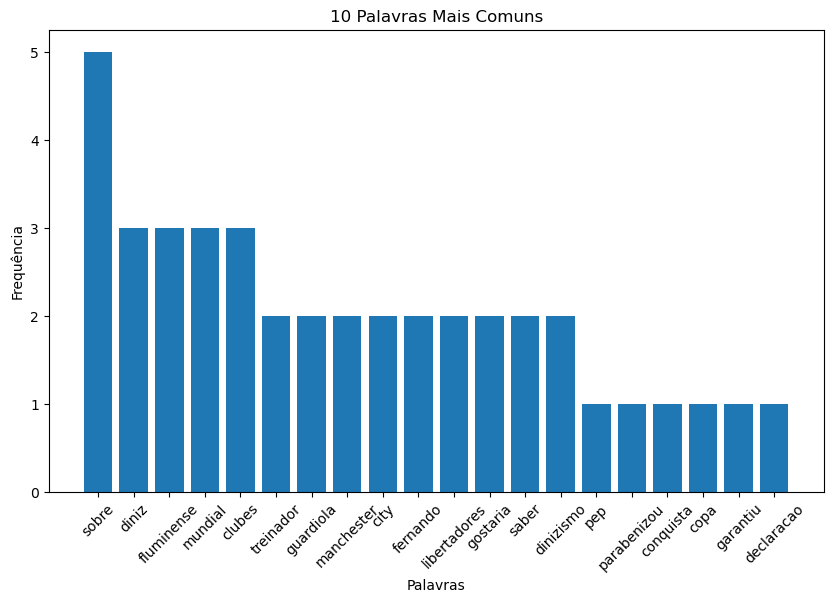

In [38]:
# Obter os 10 tokens mais comuns e suas contagens
tokens_mais_comuns = frequencia_palavras.most_common(20)
palavras, contagens = zip(*tokens_mais_comuns)

# Gráfico de Barras
plt.figure(figsize=(10, 6))
plt.bar(palavras, contagens)
plt.xlabel('Palavras')
plt.ylabel('Frequência')
plt.title('10 Palavras Mais Comuns')
plt.xticks(rotation=45)
plt.show()

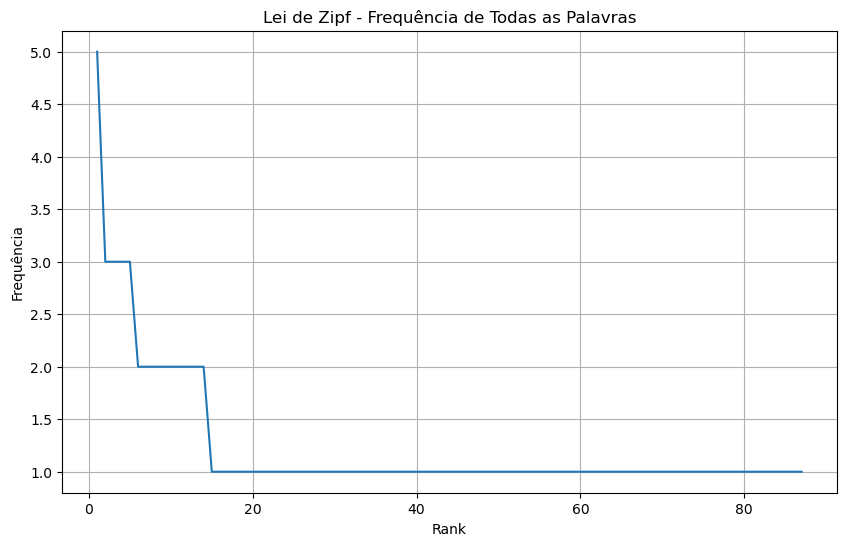

In [41]:
palavras_ordenadas = sorted(frequencia_palavras.items(), key=lambda x: x[1], reverse=True)
palavras, contagens = zip(*palavras_ordenadas)

# Plotar o gráfico da Lei de Zipf
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(palavras) + 1), contagens)
plt.xlabel('Rank')
plt.ylabel('Frequência')
plt.title('Lei de Zipf - Frequência de Todas as Palavras')
plt.grid(True)
plt.show()

## Prediction